# Prody Perturb Response Scanning (PRS): Evaluation of Sites Acting as Sensors and Effectors of Allosteric Signals

This tutorial demonstrates how to use perturbation response scanning (PRS) to determine sensors and effectors, which are important for allosteric signal transduction. The PRS approach is derived from linear response theory where perturbation forces are applied via a covariance matrix, which can be derived from elastic network models or MD simulations.

The example used in this tutorial is the Hsp70 chaperone, which we studied using this method in General et al. 2014, PLOS Comput. Biol. 10(5):e1003624. See https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4022485/

First we need to import required packages. 

In [1]:
from prody import *
import numpy as np
from pylab import *
%matplotlib inline
confProDy(auto_show=False)

@> ProDy is configured: auto_show=False


## 1. Load in the starting structure and apply the anisotropic network model to it

First, we parse a structure that we want to analyse with PRS. For this tutorial we will use the Hsp70 structure 4jne from the PDB. We first select the relevant residues and exclude flexible ends that may influence the results. In the same step, we can create a selection containing the calpha atoms (`hsp70_ca`), which we will use in downstream steps.

In [2]:
hsp70_aa = parsePDB('4jne', chain='A')
selection = hsp70_aa.select('resnum 4 to 530')
hsp70_ca = selection.select('name CA')

@> PDB file is found in working directory (4jne.pdb.gz).
@> 5315 atoms and 1 coordinate set(s) were parsed in 0.10s.
@> Secondary structures were assigned to 460 residues.


Next, create an GNM instance and calculate modes from which the covariance matrix can be calculated. We could alternatively apply the PRS to another model from which a covariance matrix could be derived such as PCA, GNM or an MD simulation.

In [3]:
gnm = GNM('hsp70')
gnm.buildKirchhoff(hsp70_ca)
gnm.calcModes(n_modes='all')

@> Kirchhoff was built in 0.03s.
@> 522 modes were calculated in 0.07s.


## 2. Calculate the normalized PRS matrix

The PRS matrix is then calculated from the covariance matrix from the GNM, which is symmetric and does not allow differentiation of sensors and effectors. We therefore normalize it by dividing each row by its diagonal element. This is handled by the function calcPerturbResponse, which also returns effectiveness and sensitivity profiles, which are the averages over the rows and columns of the normalized PRS matrix, respectively. 

In [4]:
prs_mat, eff, sens = calcPerturbResponse(gnm)

These profiles can also be calculated during analysis steps as shown later.

## 4. Identifying the effectors and sensors, and making a figure

Effectors are the most effective residues whose perturbation has large effects on the structure and dynamics. Conversely, sensors are the most sensitive residues, which respond most strongly to perturbations of effectors and themselves undergo structural changes. We can identify these two sets of residues by (a) viewing the profiles as graphs and deciding upon a reasonable cutoff or (b) coloring residues by effectiveness and sensitivity on the structure and looking at them in a molecular graphics program. For the latter approach, we write the profiles into new PDB files in place of the b-factor or occupancy field.

### a. Making graphs and plotting them alongside the matrix

This approach is implemented in the showPerturbResponse function. This function will calculate the PRS matrix (normalized covariance) as well as the effectiveness and sensitivity profiles. In order to do this, we provide a model from which the covariance matrix can be retrieved or calculated (in this case *gnm*). We also provide *hsp70_ca* so that atom information can be used too.

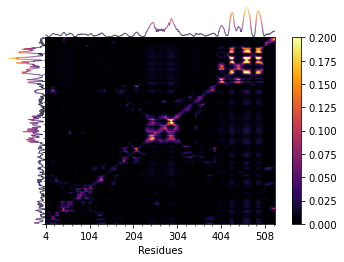

In [5]:
showPerturbResponse(prs_mat, hsp70_ca, 
                    cmap=cm.inferno, 
                    norm=Normalize(0,np.max(prs_mat)/5));

The last two options make the matrix color map match the paper and normalize the scale to make weaker signals more apparent. There are usually a few very strong signals, which otherwise drown out everything else. The current choice of capping at 1/5 of the max value looks reasonable for seeing the structure of the matrix.

## 5. Plotting or visualizing effectiveness and sensitivity profiles

We can show the effectiveness and sensitivity profiles separately to aid in identifying the effectors and sensors, which would be the residues with the highest values for these quantities, respectively. This can be shown in a plot or on a structure.

### a. Plotting profiles

We can plot profiles from showPerturbResponse by setting *show_matrix=False*. The default is to show the overall effectiveness and sensitivity profiles, which are the averages across the rows and columns. You can also select residues and show individual rows and columns corresponding to them as I will demonstrate later.

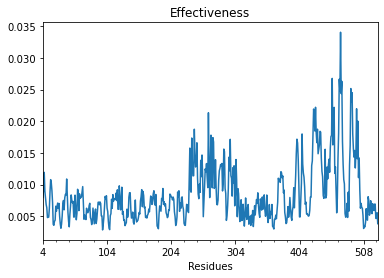

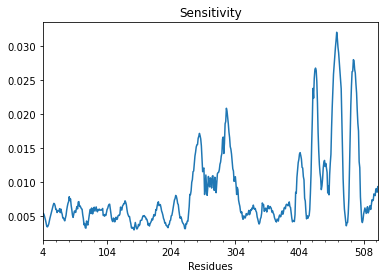

In [6]:
showPerturbResponse(prs_mat, atoms=hsp70_ca, show_matrix=False);

### b. Writing profiles to PDB files for visualization (Figures 6B-C)

In order to visualize profiles on the structure, we write new PDB files with these values in the beta-factor or occupancy column. This can be done on the all-atom structure by making use of the function extendAtomicData as follows:

In [7]:
writePDB('4jne_effectiveness.pdb', hsp70_ca, beta=eff)

'4jne_effectiveness.pdb'

To visualize this data, load the files into the graphics program of your choice and color by b-factor. In VMD, you would do this through the Graphical Representation window (from Graphics > Representations menu). The window that comes up gives various Color Method options from which you would pick Beta. The residues with high b-factor are shown in blue followed by white and ending at red for low b-factor. You can change this via the Color Controls window (Graphics > Color); this has a Color Scale tab with a Method dropdown from which you can pick other options.

## 5. Plotting or visualizing effectiveness and sensitivity profiles

To look at the effectiveness that perturbing a residue has in eliciting a response in individual residues (instead of its overall effectiveness) or to look at the sensitivity of a residue to perturbations of individual residues (instead of its overall sensitivity), we read out rows or columns from the perturbation response matrix.

### a. Plotting

For this purpose, use the showPerturbResponse function with the option *show_matrix=False*, which makes it create line graphs. By default this gives plots for the average effectiveness and sensitivity. 

You can also show plots for individual residues by slicing out rows or columns of the PRS matrix. By default, a row is selected (*axis=0*), which corresponds to the effectiveness of the selected residue(s).

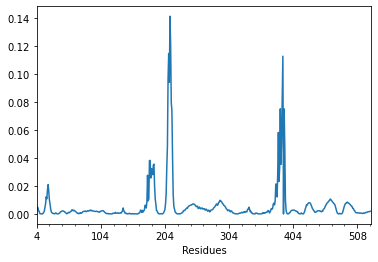

In [8]:
showPerturbResponse(prs_mat, atoms=hsp70_ca, show_matrix=False,
                    select='resnum 389');

To slice a column and show a sensitivity profile instead, we provide option *axis=1*.

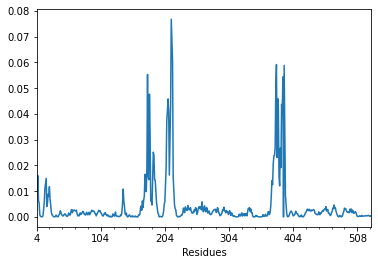

In [9]:
showPerturbResponse(prs_mat, atoms=hsp70_ca, show_matrix=False,
                    select='resnum 389', axis=1);

When multiple residues are selected, the lines are overlaid.

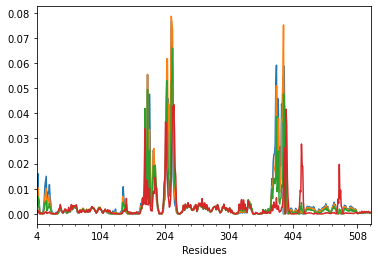

In [10]:
showPerturbResponse(prs_mat, atoms=hsp70_ca, show_matrix=False,
                    select='resnum 389 to 392', axis=1);

To show individual plots, you can provide figure names or numbers as follows:

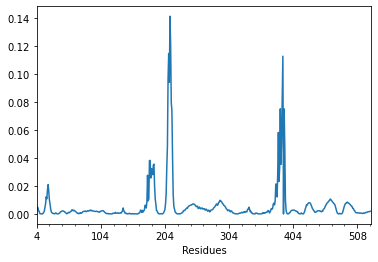

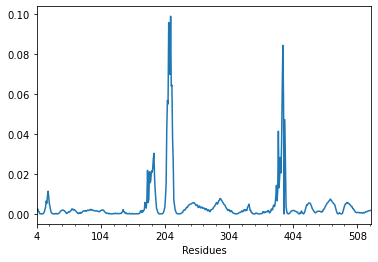

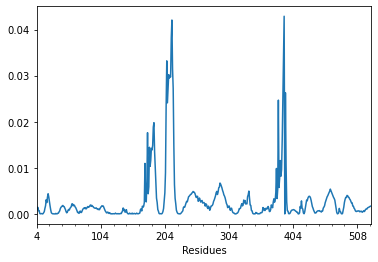

In [11]:
for i, resnum in enumerate(range(389,392)):
    showPerturbResponse(prs_mat, atoms=hsp70_ca, show_matrix=False,
                        select='resnum {0}'.format(resnum), figure=i);

### b. Visualization

We can extract residue-specific profiles by slicing the PRS matrix with a residue selection using sliceAtomicData. We then use writePDB again. 

We set *axis=0* to read out a row from the PRS matrix, which is a residue-specific effectiveness profile. For example, you could use the following command:

In [12]:
V389_effectiveness = sliceAtomicData(prs_mat, hsp70_ca, 'resnum 389', 
                                     axis=0)

In [13]:
writePDB('4jne_V389_row.pdb', hsp70_ca, betas=V389_effectiveness)

'4jne_V389_row.pdb'

You can also ask for columns (*axis=1*) rather than rows to get residue-specific sensititivity:

In [14]:
V389_sensitivity = sliceAtomicData(prs_mat, hsp70_ca, 'resnum 389', 
                                   axis=1)

In [15]:
writePDB('4jne_V389_col.pdb', hsp70_ca, betas=V389_sensitivity)

'4jne_V389_col.pdb'

We can also extend the data to include all atoms using the function extendAtomicData as follows. We need to apply the `flatten` method of `V397_sensitivity` because it has two dimensions (one of them telling us that is just one row).

In [17]:
V389_sensitivity.shape

(523, 1)

In [18]:
ext_V389_sensitivity = extendAtomicData(V389_sensitivity.flatten(), 
                                        hsp70_ca, selection)

In [19]:
writePDB('4jne_aa_V389_col.pdb', selection, betas=ext_V389_sensitivity)

'4jne_aa_V389_col.pdb'

The same applies for `V397_effectiveness` where one of the two dimensions is telling us that is just one column.

In [21]:
V389_effectiveness.shape

(1, 523)

In [22]:
ext_V389_effectiveness = extendAtomicData(V389_effectiveness.flatten(), 
                                          hsp70_ca, selection)

In [23]:
writePDB('4jne_aa_V389_row.pdb', selection, betas=ext_V389_effectiveness)

'4jne_aa_V389_row.pdb'